# NYCU LLM HW2 
## Written By 313511068 練鈞揚

In [2]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import Dataset
from rich import print
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os 

/home/keithlin/Code/NYCU_LLM_2024/HW2/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-12 03:14:59.515055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731381299.528428 3241693 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731381299.532545 3241693 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 03:14:59.546274: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in perfo

## Load data

In [3]:
def csv_to_dataset(path:str):
    return Dataset.from_pandas(pd.read_csv(path))

In [4]:
train_dataset = csv_to_dataset("./data/train.csv")
validation_dataset = csv_to_dataset("./data/validation.csv")
test_dataset = csv_to_dataset("./data/test.csv")

In [4]:
print(train_dataset, validation_dataset, test_dataset)

Dataset({
    features: ['id', 'article', 'highlights'],
    num_rows: 2871
}) Dataset({
    features: ['id', 'article', 'highlights'],
    num_rows: 134
}) Dataset({
    features: ['id', 'article', 'highlights'],
    num_rows: 115
})

In [6]:
get_max_len = lambda column, dataset: max(len(item[column].split()) for item in dataset)

train_max_len = get_max_len("article", train_dataset)
validation_max_len = get_max_len("article", validation_dataset)
test_max_len = get_max_len("article", test_dataset)
    
print(train_max_len, validation_max_len, test_max_len )

1899 1709 1801

In [7]:
get_max_len = lambda column, dataset: max(len(item[column].split()) for item in dataset)

train_max_len = get_max_len("highlights", train_dataset)
validation_max_len = get_max_len("highlights", validation_dataset)
test_max_len = get_max_len("highlights", test_dataset)
    
print(train_max_len, validation_max_len, test_max_len )

704 574 149

## Load tokenizer

In [9]:
tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-small")

In [6]:
def preprocess_function_with_tokenizer(tokenizer):
    def preprocess_function(examples):
        # 在输入文本前加上任务前缀
        inputs = [doc for doc in examples["article"]]
        model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")
        
        # 标记化目标文本
        
        labels = tokenizer(text_target=examples["highlights"], max_length=128, truncation=True, padding="max_length")
        
        model_inputs["labels"] = labels["input_ids"]
        return model_inputs
    
    return lambda examples: preprocess_function(examples)

## Process data

In [9]:
train_dataset = train_dataset.map(preprocess_function_with_tokenizer(tokenizer), batched=True)
validation_dataset = validation_dataset.map(preprocess_function_with_tokenizer(tokenizer), batched=True)
test_dataset = test_dataset.map(preprocess_function_with_tokenizer(tokenizer), batched=True)

Map: 100%|██████████| 115/115 [00:00<00:00, 1802.82 examples/s]


## Load model

In [10]:
model = AutoModelForSeq2SeqLM.from_pretrained("google-t5/t5-small")

In [12]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    logging_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=5,
    predict_with_generate=True,
    generation_max_length=128,
    logging_dir='./logs',
)

In [13]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    processing_class=tokenizer,
)

In [14]:
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,3.533100,1.370111
2,1.369300,1.295543
3,1.283500,1.274066
4,1.255600,1.267689
5,1.241800,1.266208


TrainOutput(global_step=900, training_loss=1.7366426764594185, metrics={'train_runtime': 276.6387, 'train_samples_per_second': 51.891, 'train_steps_per_second': 3.253, 'total_flos': 1942831560130560.0, 'train_loss': 1.7366426764594185, 'epoch': 5.0})

In [15]:
# Extract loss data from trainer's log history
train_loss = []
eval_loss = []
epochs_train, epochs_eval = [], []

for log in trainer.state.log_history:
    if "loss" in log.keys():
        train_loss.append(log["loss"])
        epochs_train.append(log["epoch"])
    if "eval_loss" in log.keys():
        eval_loss.append(log["eval_loss"])
        epochs_eval.append(log["epoch"])

In [16]:
epochs_train

[1.0, 2.0, 3.0, 4.0, 5.0]

In [17]:
epochs_eval

[1.0, 2.0, 3.0, 4.0, 5.0]

In [18]:
train_loss

[3.5331, 1.3693, 1.2835, 1.2556, 1.2418]

In [19]:
eval_loss

[1.3701106309890747,
 1.2955430746078491,
 1.2740657329559326,
 1.2676889896392822,
 1.2662080526351929]

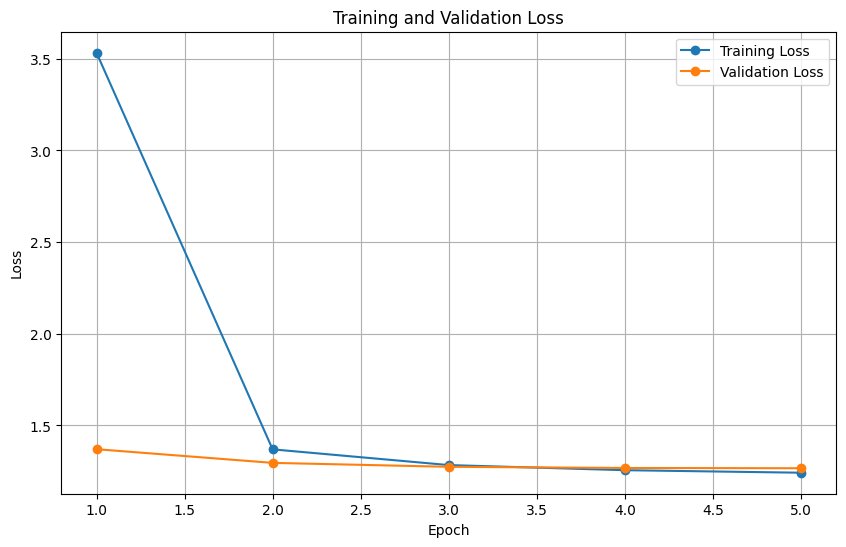

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(epochs_train, train_loss, label="Training Loss", marker="o")
plt.plot(epochs_eval, eval_loss, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()


In [18]:
from transformers import PreTrainedTokenizerFast
from collections import Counter
from dataclasses import dataclass
import numpy as np


@dataclass
class RougeScoreResult:
    precision: float
    recall: float
    fmeasure: float

    @classmethod
    def build(cls, precision: float, recall: float):
        if precision + recall <= 0:
            return cls(precision, recall, 0)

        fmeasure = 2 * (precision * recall) / (precision + recall)

        return cls(precision, recall, fmeasure)


class RougeScore:
    def __init__(
        self,
        tokenizer: PreTrainedTokenizerFast,
        rouge_n: list[int] = [1],
        rouge_l: bool = False,
    ):
        self._rouge_n = rouge_n
        self._rouge_l = rouge_l
        self._tokenizer = tokenizer

    def score(self, prediction: str, target: str) -> dict[str, RougeScoreResult]:
        target_tokens = self._tokenizer.tokenize(target)
        prediction_tokens = self._tokenizer.tokenize(prediction)
        result = {}

        if self._rouge_l:
            result["rougeL"] = RougeScore._score_lcs(target_tokens, prediction_tokens)

        for n in self._rouge_n:
            target_n_grams = RougeScore._build_n_gram(target_tokens, n)
            prediction_n_grams = RougeScore._build_n_gram(prediction_tokens, n)
            scores = RougeScore._score_n_grams(target_n_grams, prediction_n_grams)
            result[f"rouge{n}"] = scores

        return result

    def avg_score(
        self, predictions: list[str], targets: list[str]
    ) -> dict[str, RougeScoreResult]:

        all_result = [
            self.score(prediction, target)
            for prediction, target in zip(predictions, targets)
        ]
        result = dict()

        result["avg rougeL"] = np.mean([item["rougeL"].fmeasure for item in all_result])

        for n in self._rouge_n:
            result[f"avg rouge{n}"] = np.mean(
                [item[f"rouge{n}"].fmeasure for item in all_result]
            )

        return result

    @staticmethod
    def build_score(precision: float, recall: float):
        return RougeScoreResult.build(precision, recall)

    @staticmethod
    def _build_n_gram(tokens: list[str], n: int) -> dict:
        # n_grams = Counter()
        n_grams = [tuple(tokens[i : i + n]) for i in range(len(tokens) - n + 1)]
        n_grams = Counter(n_grams)
        return n_grams

    @staticmethod
    def _score_lcs(target_tokens: list[str], prediction_tokens: list[str]):

        if not target_tokens or not prediction_tokens:
            return RougeScore.build_score(precision=0, recall=0)

        # Compute length of LCS from the bottom up in a table (DP approach).
        lcs_table = RougeScore._lcs_table(target_tokens, prediction_tokens)
        lcs_length = lcs_table[-1][-1]

        precision = lcs_length / len(prediction_tokens)
        recall = lcs_length / len(target_tokens)

        return RougeScore.build_score(precision=precision, recall=recall)

    @staticmethod
    def _lcs_table(ref: list[str], can: list[str]):
        """Create 2-d LCS score table."""
        rows, cols = len(ref), len(can)
        lcs_table = [[0] * (cols + 1) for _ in range(rows + 1)]
        for i in range(1, rows + 1):
            for j in range(1, cols + 1):
                if ref[i - 1] == can[j - 1]:
                    lcs_table[i][j] = lcs_table[i - 1][j - 1] + 1
                else:
                    lcs_table[i][j] = max(lcs_table[i - 1][j], lcs_table[i][j - 1])
        return lcs_table

    @staticmethod
    def _score_n_grams(
        target_n_grams: Counter[tuple[str, ...]],
        prediction_n_grams: Counter[tuple[str, ...]],
    ):
        intersection_ngrams_count = sum(
            min(target_n_grams[ngram], prediction_n_grams.get(ngram, 0))
            for ngram in target_n_grams
        )

        # Calculate total counts for precision and recall
        target_ngrams_count = sum(target_n_grams.values())
        prediction_ngrams_count = sum(prediction_n_grams.values())

        # Calculate precision, recall, and F1
        precision = intersection_ngrams_count / max(prediction_ngrams_count, 1)
        recall = intersection_ngrams_count / max(target_ngrams_count, 1)

        return RougeScore.build_score(precision, recall)

In [18]:
# rouge = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True, tokenizer=tokenizer)
rouge = RougeScore(tokenizer=tokenizer, rouge_n=[1,2], rouge_l=True)

In [9]:
def run_test(model_in, test_dataset_in):
    
    all_predict, all_target = [], []
    for item in tqdm(test_dataset_in, desc="testing", unit="case"):
        target = item["highlights"].replace("\n", " ")
        
        input_ids = tokenizer(item["article"], return_tensors="pt",truncation=True, max_length=512).to("cuda")
        outputs = model_in.generate(**input_ids, max_length=128)
        res = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        all_predict.append(res)
        all_target.append(target)
    
    return all_predict,all_target

In [24]:
all_predict,all_target= run_test(model, test_dataset)

testing: 100%|██████████| 115/115 [01:01<00:00,  1.87case/s]


In [25]:
score = rouge.avg_score(all_predict,all_target)

In [26]:
print(score)

{'avg rougeL': 0.2620152426578431, 'avg rouge1': 0.3721902473173942, 'avg rouge2': 0.17761226385154383}

## Using hard prompt

In [10]:
def preprocess_function_v2(examples):
    # 在输入文本前加上任务前缀
    inputs = ["summarize:" + doc for doc in examples["article"]]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")
    
    # 标记化目标文本
    
    labels = tokenizer(text_target=examples["highlights"], max_length=128, truncation=True, padding="max_length")
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [7]:
test_dataset_v2 = csv_to_dataset("./data/test.csv")

In [11]:
test_dataset_v2 = test_dataset_v2.map(preprocess_function_v2, batched=True)

Map: 100%|██████████| 115/115 [00:00<00:00, 1741.53 examples/s]


In [12]:
model_v2 = AutoModelForSeq2SeqLM.from_pretrained("google-t5/t5-small")

In [13]:
model_v2 = model_v2.cuda()

In [16]:
all_predict,all_target= run_test(model_v2, test_dataset_v2)

testing: 100%|██████████| 115/115 [00:59<00:00,  1.92case/s]


In [19]:
score_v2 = rouge.avg_score(all_predict,all_target)

In [22]:
print(score_v2)

{'avg rougeL': 0.26469689384115463, 'avg rouge1': 0.3946112195917424, 'avg rouge2': 0.15714406526777147}

## Reload model

In [8]:
from transformers import T5ForConditionalGeneration, T5TokenizerFast

In [9]:
model_name = "./results/checkpoint-900"

In [10]:
tokenizer_reload : T5TokenizerFast = AutoTokenizer.from_pretrained(model_name)

In [26]:

class T5WithSoftPrompt(torch.nn.Module):
    def __init__(self, model_name, prompt_length=10):
        super().__init__()
        
        # 加载 T5 模型并冻结所有参数
        self.t5 = T5ForConditionalGeneration.from_pretrained(model_name)
        for param in self.t5.parameters():
            param.requires_grad = False  # 冻结 T5 的所有参数
        
        # 定义软提示嵌入层
        self.prompt_length = prompt_length
        embedding_dim = self.t5.get_input_embeddings().embedding_dim
        self.soft_prompt_embeddings = torch.nn.Embedding(prompt_length, embedding_dim)
        
        # 初始化软提示
        torch.nn.init.normal_(self.soft_prompt_embeddings.weight, mean=0.0, std=0.02)

    def forward(self, input_ids, attention_mask=None, labels=None):
        inputs_embeds = self._get_inputs_with_prompt(input_ids)
        
        # 更新 attention mask，增加软提示长度
        if attention_mask is not None:
            batch_size = input_ids.size(0)
            prompt_mask = torch.ones(batch_size, self.prompt_length, device=input_ids.device)
            attention_mask = torch.cat([prompt_mask, attention_mask], dim=1)
        
        # 将结果传入 T5 模型
        outputs = self.t5(inputs_embeds=inputs_embeds, attention_mask=attention_mask, labels=labels)
        return outputs
    
    def _get_inputs_with_prompt(self, input_ids):
        # 获取输入的嵌入
        inputs_embeds = self.t5.get_input_embeddings()(input_ids)
        
        # 获取批次大小并生成软提示嵌入
        batch_size = input_ids.size(0)
        prompt_ids = torch.arange(self.prompt_length, device=input_ids.device).unsqueeze(0).expand(batch_size, -1)
        prompt_embeds = self.soft_prompt_embeddings(prompt_ids)
        
        # 将软提示嵌入与输入嵌入拼接
        inputs_embeds = torch.cat([prompt_embeds, inputs_embeds], dim=1)
        return inputs_embeds

    def generate(self, input_ids, attention_mask=None, **generate_kwargs):
        inputs_embeds = self._get_inputs_with_prompt(input_ids)
        
        # 更新 attention mask，增加软提示长度
        if attention_mask is not None:
            batch_size = input_ids.size(0)
            prompt_mask = torch.ones(batch_size, self.prompt_length, device=input_ids.device)
            attention_mask = torch.cat([prompt_mask, attention_mask], dim=1)
        
        # 使用 T5 的生成功能
        outputs = self.t5.generate(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask,
            **generate_kwargs
        )
        return outputs
    
    ######### load and save 
    
    def save_model(self, save_directory):
        """保存T5模型和软提示嵌入层"""
        # 保存 T5 模型
        self.t5.save_pretrained(save_directory)
        
        # 保存软提示嵌入层的权重
        torch.save(self.soft_prompt_embeddings.state_dict(), os.path.join(save_directory, "soft_prompt_embeddings.pt"))
        
        
    @classmethod
    def from_pretrained(cls, save_directory, prompt_length=10):
        # 初始化 T5WithSoftPrompt 模型
        model = cls(save_directory, prompt_length)
        
        # 加载 T5 模型的权重
        # model.t5 = T5ForConditionalGeneration.from_pretrained(save_directory)
        
        # 加载软提示嵌入层的权重
        soft_prompt_path = os.path.join(save_directory, "soft_prompt_embeddings.pt")
        if os.path.exists(soft_prompt_path):
            model.soft_prompt_embeddings.load_state_dict(torch.load(soft_prompt_path))
        else:
            raise FileNotFoundError(f"{soft_prompt_path} not found")
        
        return model

In [12]:
train_dataset = train_dataset.map(preprocess_function_with_tokenizer(tokenizer_reload), batched=True)
validation_dataset = validation_dataset.map(preprocess_function_with_tokenizer(tokenizer_reload), batched=True)
test_dataset = test_dataset.map(preprocess_function_with_tokenizer(tokenizer_reload), batched=True)

Map: 100%|██████████| 115/115 [00:00<00:00, 1808.29 examples/s]


In [13]:
model_new = T5WithSoftPrompt(model_name, prompt_length=10)

# 冻结 T5 模型参数，仅保留 soft_prompt_embeddings 为可训练
for name, param in model_new.named_parameters():
    if "soft_prompt_embeddings" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [14]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results_soft_prompt",
    eval_strategy="epoch",
    learning_rate=2e-5,
    logging_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=5,
    predict_with_generate=True,
    generation_max_length=128,
    logging_dir='./logs',
    # save_strategy="epoch",
    save_safetensors=False
)

In [15]:
trainer = Seq2SeqTrainer(
    model=model_new,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    processing_class=tokenizer_reload,
)

In [16]:
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,1.246700,1.265786
2,1.241300,1.262420
3,1.236900,1.261532
4,1.235700,1.261120
5,1.233900,1.261040


TrainOutput(global_step=900, training_loss=1.2388994683159722, metrics={'train_runtime': 225.8293, 'train_samples_per_second': 63.566, 'train_steps_per_second': 3.985, 'total_flos': 0.0, 'train_loss': 1.2388994683159722, 'epoch': 5.0})

In [17]:
model_new.save_model("./results_softprompt")

In [18]:
train_loss = []
eval_loss = []
epochs_train, epochs_eval = [], []

for log in trainer.state.log_history:
    if "loss" in log.keys():
        train_loss.append(log["loss"])
        epochs_train.append(log["epoch"])
    if "eval_loss" in log.keys():
        eval_loss.append(log["eval_loss"])
        epochs_eval.append(log["epoch"])

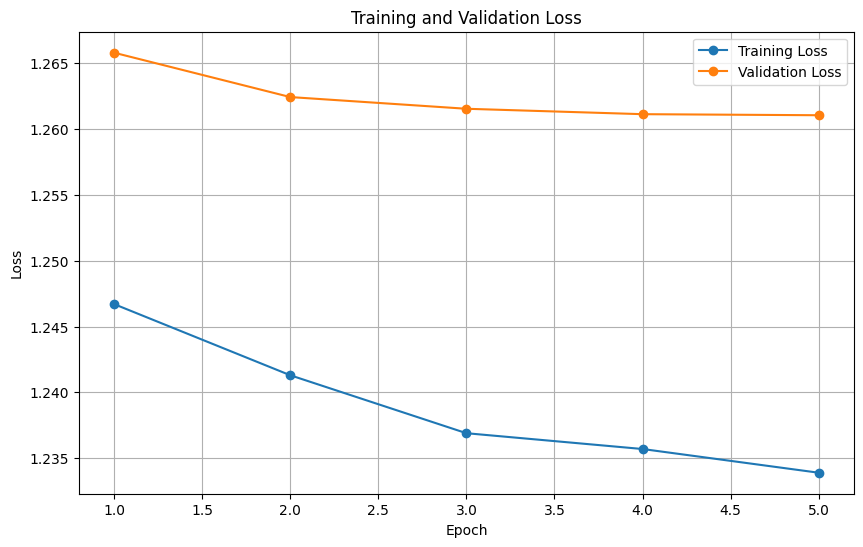

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(epochs_train, train_loss, label="Training Loss", marker="o")
plt.plot(epochs_eval, eval_loss, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [20]:
rouge = RougeScore(tokenizer=tokenizer_reload, rouge_n=[1,2], rouge_l=True)

In [21]:
def run_test_v2(model_in, test_dataset_in):
    
    all_predict, all_target = [], []
    for item in tqdm(test_dataset_in, desc="testing", unit="case"):
        target = item["highlights"].replace("\n", " ")
        
        input_ids = tokenizer_reload(item["article"], return_tensors="pt",truncation=True, max_length=512).to("cuda")
        outputs = model_in.generate(**input_ids, max_length=128)
        res = tokenizer_reload.decode(outputs[0], skip_special_tokens=True)
        
        all_predict.append(res)
        all_target.append(target)
    
    return all_predict,all_target

In [22]:
all_predict,all_target= run_test_v2(model_new, test_dataset)

testing: 100%|██████████| 115/115 [01:02<00:00,  1.83case/s]


In [23]:
score = rouge.avg_score(all_predict,all_target)

In [24]:
print(score)

{'avg rougeL': 0.2552266827739887, 'avg rouge1': 0.3578736930789929, 'avg rouge2': 0.17587939750626752}

In [27]:
# model_new_reload = T5WithSoftPrompt.from_pretrained("./results_softprompt")

/tmp/ipykernel_3237625/204036690.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.soft_prompt_embeddings.load_state_dict(torch.load(soft_prompt_path))


## Compare

## Soft prompt

In [28]:
print({"target": all_target[0] ,"predict":all_predict[0]})

{
    'target': "Zoe Waller, 31, has dermatographia and can draw designs on her own body . Condition is a type of 
urticaria - where an itchy rash appears after pressure . She says it 'doesn't hurt' and draws molecules on herself 
to teach students . Has become  famous across her university and people now make requests .",
    'predict': 'Dr Zoe Waller, 31, suffers from the skin condition dermatographia. It is a type of urticaria, or 
hives, where a raised, itchy rash appears on the skin at the slightest pressure. It is thought to be caused when 
cells under the surface of the skin release histamines as part of an allergic reaction, causing the skin to swell.'
}

## Hard prompt

In [23]:
print({"target": all_target[0] ,"predict":all_predict[0]})

{
    'target': "Zoe Waller, 31, has dermatographia and can draw designs on her own body . Condition is a type of 
urticaria - where an itchy rash appears after pressure . She says it 'doesn't hurt' and draws molecules on herself 
to teach students . Has become  famous across her university and people now make requests .",
    'predict': ',,,, occurs when cells under the surface of the skin release histamines. this is a type of 
urticaria, or hives - where a raised, itchy rash appears on the skin. this is a type of urticaria, or hives - where
a raised, itchy rash appears on the skin. this is a type of urticaria, or hives - where a raised, itchy'
}

## No prompting, just fine tune

In [5]:
model_old = AutoModelForSeq2SeqLM.from_pretrained("./results/checkpoint-900")
tokenizer_old = AutoTokenizer.from_pretrained("./results/checkpoint-900")

In [13]:
model_old = model_old.cuda()

In [8]:
test_dataset = test_dataset.map(preprocess_function_with_tokenizer(tokenizer_old), batched=True)

Map: 100%|██████████| 115/115 [00:00<00:00, 1610.43 examples/s]


In [14]:
def run_test(model_in, test_dataset_in):
    
    all_predict, all_target = [], []
    for item in tqdm(test_dataset_in, desc="testing", unit="case"):
        target = item["highlights"].replace("\n", " ")
        
        input_ids = tokenizer_old(item["article"], return_tensors="pt",truncation=True, max_length=512).to("cuda")
        outputs = model_in.generate(**input_ids, max_length=128)
        res = tokenizer_old.decode(outputs[0], skip_special_tokens=True)
        
        all_predict.append(res)
        all_target.append(target)
    
    return all_predict,all_target

In [15]:
all_predict,all_target= run_test(model_old, test_dataset)

testing: 100%|██████████| 115/115 [01:00<00:00,  1.89case/s]


In [19]:
rouge = RougeScore(tokenizer=tokenizer_old, rouge_n=[1,2], rouge_l=True)

In [20]:
score = rouge.avg_score(all_predict,all_target)

In [21]:
print(score)

{'avg rougeL': 0.2620152426578431, 'avg rouge1': 0.3721902473173942, 'avg rouge2': 0.17761226385154383}

In [22]:
print({"target": all_target[0] ,"predict":all_predict[0]})

{
    'target': "Zoe Waller, 31, has dermatographia and can draw designs on her own body . Condition is a type of 
urticaria - where an itchy rash appears after pressure . She says it 'doesn't hurt' and draws molecules on herself 
to teach students . Has become  famous across her university and people now make requests .",
    'predict': 'Dr Zoe Waller, 31, suffers from the skin condition dermatographia. Itchy weals occur after friction
such as rubbing or stroking the skin. This is a type of urticaria, or hives. It is thought to be caused when cells 
under the surface of the skin release histamines.'
}